- References:
    - `lr finding algorithm` in paper [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186).
    - `lr_find()` in `Fast AI`. 
    - [pytorch-lr-finder.git](https://github.com/davidtvs/pytorch-lr-finder)
    - [Use optimizer in pytorch with Fast AI Learner]
- Take away techs:
    - `lr_find()` use naive pytorch & with `FastAI` APIs.
    - How to set optimizer's lr without defining a scheduler.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [3]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

### Load MNIST Dataset

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
orig_train_ds = tv.datasets.MNIST(root='data/', train=True, download=True, transform=transform)
orig_test_ds = tv.datasets.MNIST(root='data/', train=False, transform=transform)

In [6]:
# Split MNIST Dataset into train and valid
train_x, valid_x, train_y, valid_y = train_test_split(orig_train_ds.data.unsqueeze(1).float(), orig_train_ds.targets, test_size=0.1)

In [7]:
train_ds = TensorDataset(train_x, train_y)
valid_ds = TensorDataset(valid_x, valid_y)
test_ds  = TensorDataset(orig_test_ds.data.unsqueeze(1).float(), orig_test_ds.targets)

In [8]:
# Wrap dataset into dataloader
bs = 128
train_dl = DataLoader(dataset=train_ds, batch_size=bs, shuffle=True, num_workers=8)
valid_dl = DataLoader(dataset=valid_ds, batch_size=bs, shuffle=False, num_workers=8)
test_dl  = DataLoader(dataset=test_ds,  batch_size=bs, shuffle=False, num_workers=8)

### Define model

In [9]:
class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

In [10]:
def getNewModel():
    return nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.AdaptiveAvgPool2d((1,1)),
        Flatten(),
        nn.Linear(in_features=128, out_features=32),
        nn.ReLU(),
        nn.Dropout(p=0.2),

        nn.Linear(32, 10),
    )

### Train models in regular manner

In [11]:
def trainCharRecog(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.
    total = 0.
    char_correct = 0.
    ang_correct = 0.
    for batch_idx, (imgs, tchar) in enumerate(train_loader):
        imgs, tchar = imgs.cuda(), tchar.cuda()
        schar = model(imgs)
        loss = criterion(schar, tchar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        _, char_predict = torch.max(schar.data,1)
        
        total += tchar.size(0)
        char_correct += char_predict.eq(tchar.data).cpu().sum().item()
        
    return train_loss/batch_idx, char_correct/total

In [12]:
def evalCharRecog(model, test_loader, criterion):
    model.eval()
    valid_loss = 0.
    total = 0.
    char_correct = 0.
    ang_correct = 0.
    with torch.no_grad():
        for batch_idx, (imgs, tchar) in enumerate(test_loader):
            imgs, tchar = imgs.cuda(), tchar.cuda()
            schar = model(imgs)
            loss = criterion(schar, tchar)
            valid_loss += loss.item()

            _, char_predict = torch.max(schar.data,1)
            total += tchar.size(0)
            char_correct += char_predict.eq(tchar.data).cpu().sum().item()
    return valid_loss/batch_idx, char_correct/total

In [13]:
torch.backends.cudnn.benchmark = True

In [14]:
# model = CharRecogModel()
model = getNewModel()
model = model.cuda()

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1E-2, momentum=0.9, weight_decay=1E-4)

In [16]:
train_loss_hist = []
valid_loss_hist = []
train_char_acc_hist = []
train_ang_acc_hist = []
valid_char_acc_hist = []
valid_ang_acc_hist = []
# correct = 0
# total = 0

In [17]:
for epoch in tqdm(range(100)):
    train_loss, train_char_acc = trainCharRecog(model, train_dl, optimizer, criterion)
    
    
    valid_loss, valid_char_acc = evalCharRecog(model, valid_dl, criterion)
    
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)
    train_char_acc_hist.append(train_char_acc)
    valid_char_acc_hist.append(valid_char_acc)
    


100%|██████████| 100/100 [06:37<00:00,  3.97s/it]


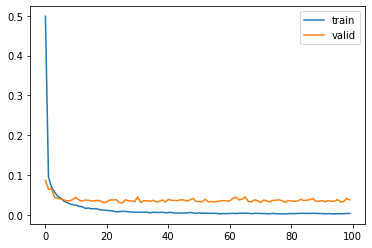

In [18]:
plt.plot(train_loss_hist, label="train")
plt.plot(valid_loss_hist, label="valid")
plt.legend()

Text(0, 0.5, 'Acc of Chars')

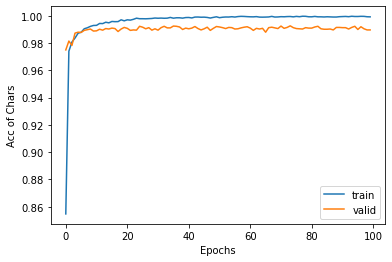

In [19]:
plt.plot(train_char_acc_hist, label="train")
plt.plot(valid_char_acc_hist, label="valid")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Acc of Chars")

In [20]:
test_loss, test_acc = evalCharRecog(model, test_dl, criterion)

In [21]:
test_acc

0.9915

### LR Finder Implementation 

- Steps:
    - 1. Increase lr exponentially to generate the testing range.
    - 2. Update model using different lr, and record the batch loss.
    - 4. Smooth the loss.
    - 3. Find the optimal lr:
        - Choose the value that is 10 times smaller than the value of lr when the smallest batch loss is achived.
        - Choose the value when the loss decreases the most quickly.
    - 4. Restore the model with the initialized parameters.

In [22]:
model = getNewModel()
model = model.cuda()

In [23]:
torch.save(model.state_dict(), "_tmp.pth")

In [24]:
lr_high = 10
lr_low  = 1E-7
num_it = 100
loss_hist = []

In [ ]:
lr_list = [lr_low*(lr_high/lr_low)**(i/num_it) for i in range(num_it+1)]

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1E-2, momentum=0.9, weight_decay=1E-4)

In [27]:
def setLrForOpt(opt, lr):
    for param in opt.param_groups:
        param["lr"] = lr

In [28]:
cnt = 0
for epoch in range(num_it):
    if cnt>num_it: break
    for imgs, tchar in train_dl:
        if cnt>num_it: break
        setLrForOpt(optimizer, lr_list[cnt])
        imgs, tchar = imgs.cuda(), tchar.cuda()
        schar = model(imgs)
        loss = criterion(schar, tchar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_hist.append(loss.item())
    
        cnt += 1
    
        

In [29]:
beta = 0.95
avg_loss = 0.
avg_loss_hist = []
scale_factor = 1.
best_loss = np.inf
for i, loss in enumerate(loss_hist):
    if i==0: avg_loss = loss
    else:
        avg_loss = (1-beta)*loss+(beta)*avg_loss
    if avg_loss<best_loss: best_loss=avg_loss
    if avg_loss>4*best_loss: break
    scale_factor *= beta
#     avg_loss = avg_loss/(scale_factor)
    avg_loss_hist.append(avg_loss)
    

In [57]:
skip_beg = 10
skip_end = 5

In [58]:
avg_loss_eff_hist = avg_loss_hist[skip_beg:-skip_end]
lr_eff_hist = lr_list[:len(avg_loss_hist)]
lr_eff_hist = lr_eff_hist[skip_beg:-skip_end]

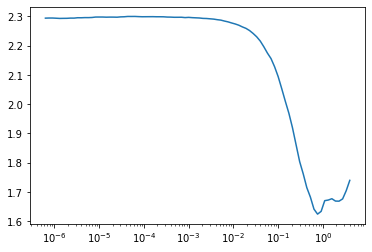

In [59]:
plt.plot(lr_eff_hist, avg_loss_eff_hist)
plt.xscale("log")

In [65]:
print(f"Suggested lr by min: {lr_eff_hist[np.argmin(avg_loss_eff_hist)]/10}")
print(f"Suggested lr by min: {lr_eff_hist[np.argmin(np.gradient(avg_loss_eff_hist))]}")

Suggested lr by min: 0.07585775750291836
Suggested lr by min: 0.25118864315095824


In [48]:
# Load the initial parameters
model.load_state_dict(torch.load("_tmp.pth"))

<All keys matched successfully>

#### Train Models in Fast AI Manner

In [49]:
import os
import sys
sys.path.append(os.environ.get("FASTAI_PATH"))

In [50]:
import torch.nn.functional as F

In [51]:
from fastai.vision import *
from fastai.data.core import DataLoaders
from fastai.vision.all import *

In [52]:
data = DataLoaders.from_dsets(train_ds, valid_ds).cuda()

In [53]:
model_fastai = getNewModel()
criterion = nn.CrossEntropyLoss()

In [54]:
def opt_func(ps, lr): return OptimWrapper(optim.SGD(ps, lr=lr, momentum=0.9, weight_decay=1E-4))

In [55]:
learn = Learner(data, model_fastai, loss_func=criterion, opt_func=opt_func, metrics=accuracy) #F.cross_entropy

SuggestedLRs(lr_min=0.13182567358016967, lr_steep=0.2089296132326126)

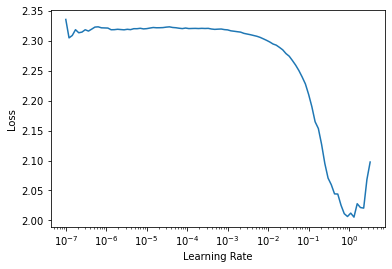

In [56]:
learn.lr_find()

In [42]:
learn.fit_one_cycle(10, 0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.136161,0.133188,0.958000,00:12
1,0.079643,0.058287,0.982167,00:11
2,0.068184,0.045354,0.986167,00:10
3,0.040188,0.040304,0.988333,00:11
4,0.041877,0.043317,0.987667,00:11
5,0.039987,0.035731,0.990000,00:11
6,0.029135,0.031449,0.991167,00:12
7,0.015412,0.028611,0.992000,00:10
8,0.013187,0.027435,0.993000,00:12
9,0.010075,0.027611,0.992833,00:11


In [43]:
test_loss, test_acc = evalCharRecog(model_fastai, test_dl, criterion)

In [44]:
test_acc

0.993

#### Quick & Dirty Test Code

In [41]:
scheds = SchedExp(1E-7, 10)

In [45]:
learn.smooth_loss

tensor(0.0085)

In [46]:
cb=LRFinder(start_lr=1E-7, end_lr=10, num_it=100, stop_div=True)

In [48]:
cb.scheds

{'lr': <fastai.callback.schedule._Annealer at 0x7f12cc132e50>}

In [63]:
learn.opt.param_groups[0]["lr"]

3.018509358403143e-07

In [53]:
??learn.opt

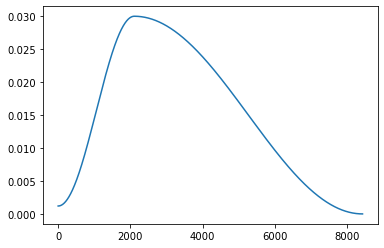

In [68]:
plt.plot(learn.recorder.lrs)